# Denoising

From our perspective of annealed Langevin dynamics, let's consider the extreme case: let's aim for starting with _pure_ noise, and treat the annealing steps as a continuous time dimension. We define our pure noise starting time as $t=T$, and then reduce the noise to zero with a continuous _noising schedule_ at $t=0$. When we focus on Gaussian noise $\mathcal{N}$, combining multiple instances of Gaussian noise is still Gaussian. Hence, this actually gives us a Markov chain with a **forward** chain that adds noise in a very controllable way. We'll call the forward process $q$ and denote the function for the standard deviation with $\beta$, giving

$$
q(x_{1:T}|x_0) := \prod_{t=1}^T q(x_t|x_{t-1})
\text{  with  }
q(x_t|x_{t-1}) = \mathcal{N} \big( \sqrt{1-\beta_t} x_{t-1}, \beta_t I \big)  ~.
$$

The process that we've been considering in the previous sections above (the "Langevin dynamics") then represents the **reverse** process. We'll directly denote it with $p_\theta$ as this is what we want to learn later on. The reverse process over the diffusion time $t$ is given by:

$$
p_\theta(x_{0:T}) := p(x_T) \prod_{t=1}^T p_\theta(x_{t-1}|x_t)
\text{  with  }
p_\theta(x_{t-1}|x_t) = \mathcal{N} \big( \mu_\theta(x_t, t), \beta_t I \big)
$$

which looks quite simple at first, but we've simply hidden all the difficulties in $\mu_\theta$, the learned mean of our distributions, giving the key building block of $p_\theta$.

Thanks to our construction with the Gaussians having standard deviation $\beta_t$, we have an analytic form for every step along the way:
Given a data point $x_0$￼, we can sample the noisy latent state $x_t$￼ from the forward Markov chain via

$$
    q(x_t|x_0) = \mathcal{N}(\sqrt{\overline{\alpha}_t}x_0, (1-\overline{\alpha}_t)I)) ,
$$

with the inverted weights $\alpha_t = 1 - \beta_t$ and alphas accumulated for time $t$ denoted by
$\overline{\alpha}_t= \prod_{s=1}^t \alpha_s$.

![Divider](resources/divider-gen6.jpg)

## Latent Variable Models

Conceptually, this formulation gives us what's called a _latent variable model_ in the ML community. Instead of the somewhat arbitrary in between states of the Annealed Langevin Dynamics above, we now have explicitly modeled _latent_ states along the diffusion time $t$. Our distribution for targets ￼$ x_0 \sim q(x_0) $ is of the form  $ p_\theta(x_0) = \int p_\theta(x_{0:T})dx_{1:T} , $   where  $x_1,...,x_T$￼ are latents with the same dimensionality as $x_0$.

Above we've directly trained models with the gradient of the perturbed data to get the score. How does this work in the context of these continually changing latents?
The exact marginal likelihood of the diffusion process involves an intractable integral, but the step-wise accumulation of Gaussian noise represents a variational lower bound that we can use instead. Via _Jensen's inequality_ for the log marginal likelihood, we obtain an expression for the _evidence lower bound_ (ELBO)

$$
\log p_\theta(x_0) \geq \mathbb{E}_{q(x_1, \ldots, x_T | x_0)} \left[ \log \frac{p_\theta(x_0, x_1, \ldots, x_T)}{q(x_1, \ldots, x_T | x_0)} \right].
$$

Expanding and simplifying the terms we get a lower bound for the maximum likelihood objective:
$$
\mathbb{E}[- \log p_\theta(x_0)] \leq \mathbb{E} \left[ - \log p(x_T) - \sum_{t \geq 1} \log \frac{p_\theta(x_{t-1}|x_t)} {q(x_t|x_{t-1})} \right]
$$

Note that we've also made use of the Bayes conditioning trick from the top here. This training objective can be reformulated in terms of a KL divergence, to give three terms:

$$
\begin{aligned}
\mathbb{E} & \left[ L_T  +  L_{t-1}  +  L_1 \right] = \\
\mathbb{E} & \left[ \mathrm{KL}(q(x_T|x_0) ||p(x_T)) + \sum_{t > 1} \mathrm{KL}(q(x_{t-1}|x_t, x_0)|| p_\theta(x_{t-1}|x_t))  - \log p_\theta(x_0|x_1) \right]
\end{aligned}
$$

This looks complicated, but the three terms have distinct meanings:
- the first one, $L_T$ does not depend on $\theta$;
- the last one, $L_1$, is easy to train with;
- and the middle $L_{t-1}$ term is just the KL divergence between two known Gaussian distributions.

Hence, the middle term $L_{t-1}$ is key, and we actually have the Gaussians under control with the $\alpha$ and $\beta$ terms above. For the forward process the corresponding expressions are a bit lengthy, but we can write them out. This gives the conditional Gaussian
$q(x_{t-1}|x_t,x_0) = \mathcal{N} \big( \tilde{\mu}_t(x_t, x_0), \tilde{\beta}_tI \big)$, with mean and standard deviation being

$$
\tilde{\mu}_t(x_t, x_0) = \frac{\sqrt{\overline{\alpha}_{t-1}}\beta_t}{1-\overline{\alpha}_t} x_0 + \frac{\sqrt{\alpha_t}(1-\overline{\alpha}_{t-1})}{1-\overline{\alpha}_t}x_t
\text{ and }
\tilde{\beta}_t = \frac{1 - \overline{\alpha}_{t-1}}{1- \overline{\alpha}_t} \beta_t
$$

This actually gives us a feasible training objective that has been used in a number of papers, but we don't need to stop there. Rather we can further simplify this construction by realizing that we're dealing with noise $\epsilon$ being added to our means ($x+\epsilon$). Instead of predicting the means (the signal  $x$ itself), predicting the noise $\epsilon$ on top of it is easier, and by subtracting it we likewise get $x$. In the terminology above, we get

$$
x_t(x_0, \epsilon) = \sqrt{\overline{a}_t}x_0 + \sqrt{1-\overline{\alpha}_t} \epsilon \text{ for } \epsilon \sim \mathcal{N}(0,I) ,
$$ (ddpm-xt)

and instead of predicting the mean  $\mu_\theta(x_t, t)$  we predict the noise  $\epsilon_\theta(x_t,t)$  from which we can compute the mean via

$$
\mu_\theta(x_t, t) = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1-\alpha_t}{\sqrt{1-\overline{\alpha}_t}} \epsilon_\theta(x_t, t)\right) .
$$

This simplifies the loss term $L_{t-1}$ from above to

$$
\mathbb{E}_{x_0, \epsilon} \left[ \frac{\beta_t^2}{2 \beta_t \alpha_t (1-\overline{\alpha}_t)} || \epsilon - \epsilon_\theta(\sqrt{\overline{\alpha}}_t x_0 + \sqrt{1-\overline{\alpha}_t} \epsilon, t) ||^2 \right] + C ,
$$

and even better, it turns out we can remove the first $\beta^2$ factor. People have noticed that it actually provides a sub-optimal scaling, and removing it increases the weighting for samples with small $\beta$ values at the end of the reverse chain. This gives a simplified denosing loss of

$$
L_\mathrm{DM}(\theta) = \mathbb{E}_{t, x_0, \epsilon} \left[ || \epsilon - \epsilon_\theta \big (
    x_t(x_0, \epsilon), t
    \big)  ||^2 \right] ,
$$

where can easily compute correct values for
$x_t$ by mixing $\sqrt{\overline{a}_t}x_0$ with the right amount of noise
 $ \sqrt{1-\overline{\alpha}_t} \epsilon$, as outlined above in equation {eq}`ddpm-xt`.

## Full Denoising Algorithm

This extremely simple $L^2$ loss is really the reason for the break-through success of this approach, as it's very simple to compute, and very stable.
This training variant often goes under the name _denoising diffusion probablistic models_ (DDPM). Unlike, e.g. GANs, for which one needs to train with a fragile balance of two networks, we only need to consider a fully supervised loss for training DDPMs. This comes at the cost of increased computational resources, though. Before addressing the computational challenges (these have also been mostly resolved by now), let's re-cap that algorithms for training and inference that we get from this denoising objective.

```{figure} resources/prob02-ddpm.jpg
---
height: 240px
name: probmod-ddpm
---
DDPM process (in contrast to CNFs): denoising the simple base distribution (left) over a large number of denoising steps to arrive at a sample from the target distribution (right).
```


The training procedure can be summarized in pseudo-code with:

```{prf:algorithm} DDPM Training
:label: ddpm-training

**Inputs** Target distribution $q$, noise schedule $\overline{\alpha}$

**Output** Trained noise estimator NN $\epsilon_\theta$

1. repeat until converged:

    2. $x_0 \sim q(x_0)$
    3. $t \sim \text{Uniform}(1,\dots,T)$
    4. $\epsilon \sim \mathcal N(0,I)$
    5. $x_t = \sqrt{\overline{a}_t}x_0 + \sqrt{1-\overline{\alpha}_t} \epsilon$
    6. optimizer_step($ \nabla_\theta ||\epsilon - \epsilon_\theta(x_t,t)||^2 $)

7. return $\epsilon_\theta$

```

We uniformly sample an integer time $t$, and compute the noise sample $x_t$. This is quite simple, just blend a sample from step 0 of our forward process, $x_0$ with uniform noise according to the weight $\overline{\alpha}_t$. Let the network try to estimate the noise given $x_t$ and the time $t$, and then do a step with your favorite optimizer (usually Adam) along the gradient of the $L^2$ loss. Note that the noise schedule $\overline{\alpha}_t$ and the corresponding coefficients can be precomputed for a chosen number of steps $T$. This reduces the calculation to a simple lookup at training time. The loss is particularly simple as we can omit the weighting of the noise schedule as explained above.

For inference, we need to properly evaluate the weighting terms, which makes the process slightly more complicated. The weighting can be precomputed just like for training, but the expensive bit is that we now need to go through all $T$ steps to fully denoise the sample:

```{prf:algorithm} DDPM Inference
:label: ddpm-inference

**Inputs** Noise estimator $\epsilon_\theta$, noise schedule $\alpha,\overline{\alpha},\sigma$

**Output** Sample from distribution $p$

1. $x \sim \mathcal N(0,I)$
2. for $t = T,\dots,1$:

    3. if $t>1$: $z \sim \mathcal N(0,I)$
    4. else:     $z = 0$
    5. $x = \frac{1}{\sqrt{\alpha_t}} \left( x - \frac{1-\alpha_t}{\sqrt{1-\overline{\alpha}_t}} \epsilon_\theta(x, t)\right) + \sigma_t z$

6. return $x$
```

This means we have to sequentially evaluate the trained neural network $\epsilon_\theta$ for $T$ times, and the original DDPM papers actually used $T=1000$ to obtain very high quality samples. In practice, $T$ can be reduced significantly, by ca. one order of magnitude, without while still giving excellent results, but this nonetheless means we have to evaluate the network around 100 times.

While this is clearly more expensive than the deterministic networks we have used in previous chapters, which produced the mean output in a single pass, the powerful, fundamental change is that the DDPM network can learn and reliably reproduce distributions. I.e., if your data for a single flow input contains 20% solutions that spin left, and 80% that turn right, the trained DDPM network will reproduce these solutions with the right probability. When you repeatedly run inference with different initial noise values for $x$, you will see left spins with a probability of 0.2, and right spinning solutions with 0.8. The network itself is of course still deterministic, for a constant initial $x$ in line 1 of the inference algorithm, it will always produce the same output.

Another powerful aspect that we'll get back to is also that these networks can be reliable conditioned to steer the generated samples. This is highly important for our initial goals from simulation-based inference: we like to learn the posterior distribution $p(x|y)$ that produces the correct outputs for a given observation $y$. Looking ahead, three important extensions of the algorithm so far are to be addressed:
- Faster inference speed, primarily getting away with fewer network calls.
- Conditioning on external parameters and observations.
- And in the context of physics simulations, we'd of course like to bring back our prior knowledge in the form of PDE-base constraints.

Nonetheless, we've made the most important first step with DDPMs now: we have turned the deterministic networks into tools for probabilistic inference that robustly learn and reproduce complex distributions. Before starting with source code examples, let's address the computational overhead: DDPMs require a _large_ number of denoising steps. The resulting models can be orders of magnitude more expensive to run than their deterministic counterparts. Hence the central question is, how can we  reduce the number of required steps without loosing accuracy for the posterior?

## Training with DDPM

Let's see how well these ideas work for our Gaussian mixture (GM) case. To make this a standalone notebook, we first initialize the same two-peak GM case that was also used for the normalizing flows and score tests.

In [ ]:
import numpy as np

class GaussianMixture:
    def __init__(self, parameters):
        self.parameters = parameters
        self.distributions = [
            {
                'mean': np.array(dist['mean']),
                'std': np.array(dist['std']),
                'cov': np.diag(np.array(dist['std']) ** 2)
            }
            for dist in parameters
        ]

    def sample(self, num_samples):
        samples = []
        num_distributions = len(self.distributions)
        for _ in range(num_samples):
            idx = np.random.randint(num_distributions)  # Choose a random Gaussian
            dist = self.distributions[idx]
            sample = np.random.multivariate_normal(mean=dist['mean'], cov=dist['cov'])
            samples.append(sample)
        return np.array(samples)

parameters = [
    {"mean": [0, 0], "std": [1, 1]},
    {"mean": [3, 2], "std": [0.5, 0.5]}
]
mixture = GaussianMixture(parameters)

### Define the Forward Process

Next, we implement the forward process for DDPM, which takes our GM distribution, and adds increasing amounts of noise until all traces of information left in the samples are removed. The visualizations below show this destructive process in action...

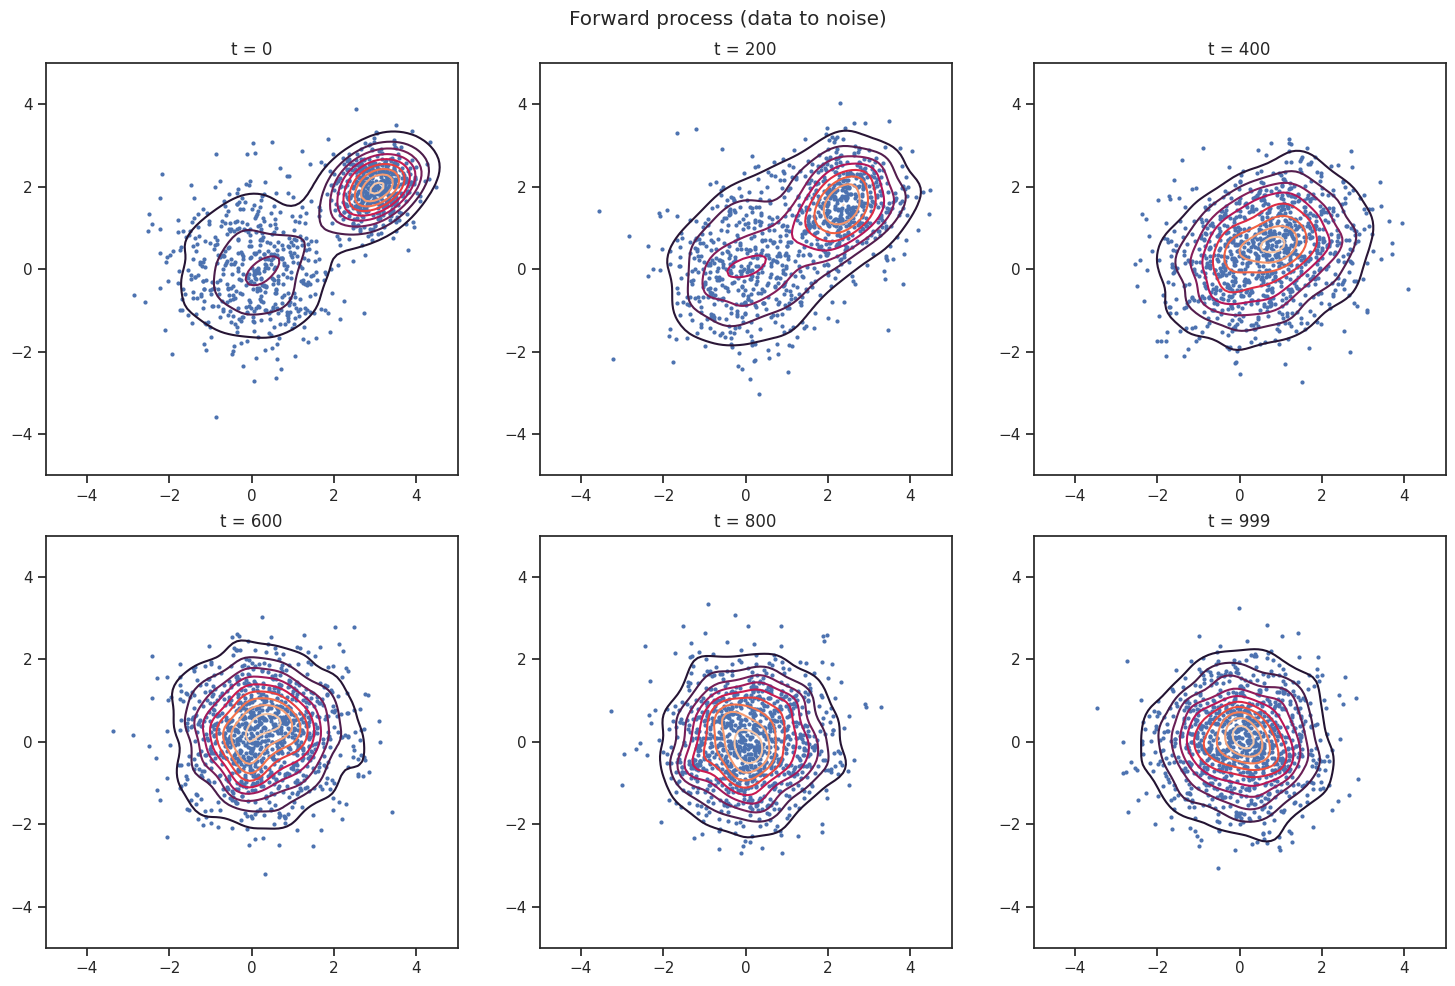

In [6]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")

class DDPMForwardProcess:
    def __init__(self, num_timesteps=1000):
        self.num_timesteps = num_timesteps

        # Standard beta schedule from DDPM paper
        scale = 1000 / num_timesteps
        beta_start = scale * 0.0001
        beta_end = scale * 0.02
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)

        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_betas = torch.sqrt(self.betas)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - self.alphas_cumprod)

    def forward_process(self, x_0, t):
        epsilon = torch.randn_like(x_0)
        mean = self.sqrt_alphas_cumprod[t] * x_0
        std = self.sqrt_one_minus_alphas_cumprod[t]
        return mean + std * epsilon, epsilon

    def visualize_forward_process(self, mixture, num_samples=1000):

        timesteps_to_show=[0, 200, 400, 600, 800, 999]
        x_0 = torch.FloatTensor(mixture.sample(num_samples))

        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.ravel()

        xx, yy = np.mgrid[-5:5:100j, -5:5:100j]
        positions = np.vstack([xx.ravel(), yy.ravel()])

        for idx, t in enumerate(timesteps_to_show):
            x_t, _ = self.forward_process(x_0, t)
            samples = x_t.numpy()

            from scipy.stats import gaussian_kde
            kernel = gaussian_kde(samples.T)
            density = np.reshape(kernel(positions).T, xx.shape)

            ax = axes[idx]

            ax.contour(xx, yy, density, levels=10, alpha=1.0)

            ax.scatter(samples[:, 0], samples[:, 1], alpha=1.0, s=4)

            ax.set_xlim(-5, 5)
            ax.set_ylim(-5, 5)
            ax.set_aspect('equal')
            ax.set_title(f't = {t}')

        plt.suptitle("Forward process (data to noise)")

        plt.tight_layout()
        plt.show()

ddpm = DDPMForwardProcess(num_timesteps=1000)
ddpm.visualize_forward_process(mixture)


It's visible here that the two peaks from $t=0$ start to disappear after ca. 200 steps of adding noise, and, visually, form a single Guassian peak centered around zero.

### Dataset and Dataloader

The next code cell defines a small dataset class that we will use to train the DDPM. It precomputes the correct alpha and beta values for each $t$ so that we can quickly pull up samples with varying amounts of noise for training.

In [7]:
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import numpy as np

class ForwardDiffusionDataset(Dataset):
    def __init__(self, num_samples, input_dim,
                 T, mixture, beta_value=0.02):
        super().__init__()
        self.num_samples = num_samples
        self.input_dim = input_dim
        self.T = T
        self.beta_value = beta_value
        self.gm = mixture

        self.betas = beta_value * torch.ones(T)
        self.alphas = 1 - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)

        self.x0 = torch.FloatTensor(self.gm.sample(num_samples))

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        x0_sample = self.x0[idx]
        t = torch.randint(low=1, high=self.T + 1, size=(1,)).item()
        eps = torch.randn(self.input_dim)
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t - 1])
        sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar[t - 1])

        x_t = sqrt_alpha_bar * x0_sample + sqrt_one_minus_alpha_bar * eps

        return x_t, torch.tensor(t, dtype=torch.float32), eps

Next, we'll define a simple network, much in line with the previous score networks. In this case, three hidden layers suffice to learn the denoising task. The main difference now is that the network receives the denoising  time `t` instead of the perturbation amount from before.

In [ ]:
class DdpmNet(nn.Module):
    def __init__(self, in_dim=2, time_dim=1, hidden_dim=128, out_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim + time_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x, t):
        t = t.unsqueeze(1)
        xt = torch.cat([x, t], dim=1)
        return self.net(xt)

### Initialization and Training

In [ ]:
num_samples = 10000
input_dim = 2
T = 1000
dataset = ForwardDiffusionDataset(num_samples=num_samples, input_dim=input_dim, T=T, mixture=mixture, beta_value=0.02)
batch_size = 64
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# %% Training the DDPM model
time_dim = 1
hidden_dim = 128
model = DdpmNet(in_dim=input_dim, time_dim=time_dim, hidden_dim=hidden_dim, out_dim=input_dim)
optimizer = Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

epochs = 100
model.train()
for epoch in range(1, epochs + 1):
    epoch_loss = 0
    for x_t_batch, t_batch, eps_batch in data_loader:
        optimizer.zero_grad()
        # Normalize time t to range [0,1]
        t_norm = t_batch / T
        eps_pred = model(x_t_batch, t_norm)
        loss = loss_fn(eps_pred, eps_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(data_loader)
    print(f"Epoch {epoch}/{epochs}, Loss: {avg_loss:.4f}")


Epoch 1/100, Loss: 0.1529
Epoch 2/100, Loss: 0.0871
Epoch 3/100, Loss: 0.0863
Epoch 4/100, Loss: 0.0747
Epoch 5/100, Loss: 0.0759
Epoch 6/100, Loss: 0.0737
Epoch 7/100, Loss: 0.0715
Epoch 8/100, Loss: 0.0742
Epoch 9/100, Loss: 0.0706
Epoch 10/100, Loss: 0.0704
...
Epoch 90/100, Loss: 0.0631
Epoch 91/100, Loss: 0.0592
Epoch 92/100, Loss: 0.0597
Epoch 93/100, Loss: 0.0595
Epoch 94/100, Loss: 0.0570
Epoch 95/100, Loss: 0.0632
Epoch 96/100, Loss: 0.0609
Epoch 97/100, Loss: 0.0570
Epoch 98/100, Loss: 0.0580
Epoch 99/100, Loss: 0.0606
Epoch 100/100, Loss: 0.0624


### Inference with the Reverse Process

Above, it was enough to have single steps of the denoising process for training the network. At inference time, we now need to perform the whole denoising process: starting from an initial pure noise sample, updating it over the course of 1000 iterations for denoising, to finally obtain a sample from the target distribution at the end.

The code below implements this process, and records different snapshots of the denoising process for visualization.

In [ ]:
n_infer = 1000

betas = 0.02 * torch.ones(T)
alphas = 1 - betas
alpha_bar = torch.cumprod(alphas, dim=0)

with torch.no_grad():
    x = torch.randn(n_infer, input_dim)

    record_steps = {999, 500, 200, 100, 50, 1}
    snapshots = {}

    for t in range(T, 0, -1):

        t_tensor = (torch.ones(n_infer) * t / T).float()
        eps_theta = model(x, t_tensor)

        beta_t = betas[t - 1]
        alpha_t = alphas[t - 1]
        alpha_bar_t = alpha_bar[t - 1]

        coef = beta_t / torch.sqrt(1 - alpha_bar_t)
        x = (1 / torch.sqrt(alpha_t)) * (x - coef * eps_theta)

        if t > 1:
            sigma_t = torch.sqrt(beta_t)
            x = x + sigma_t * torch.randn_like(x)

        if t in record_steps:
            snapshots[t] = x.clone().cpu().numpy()

### Visualize the Sampled Trajectories

Next, we visualize how the initial distribution slowly turns into the target distribution from our GM case.

In [12]:
import matplotlib.pyplot as plt

def get_angle_colors(positions):
    angles = np.arctan2(positions[:, 1], positions[:, 0])
    angles_deg = (np.degrees(angles) + 360) % 360
    colors = np.zeros((len(positions), 3))
    for i, angle in enumerate(angles_deg):
        segment = int(angle / 120)
        local_angle = angle - segment * 120
        if segment == 0:    # 0 degrees to 120 degrees (R->G)
            colors[i] = [1 - local_angle/120, local_angle/120, 0]
        elif segment == 1:  # 120 degrees to 240 degrees (G->B)
            colors[i] = [0, 1 - local_angle/120, local_angle/120]
        else:               # 240 degrees to 360° (B->R)
            colors[i] = [local_angle/120, 0, 1 - local_angle/120]

    return colors

def visualize_snapshots(snapshots):

    sorted_steps = sorted(snapshots.keys(), reverse=True)
    n_plots = len(sorted_steps)

    fig, axes = plt.subplots(2, 3, figsize=(5 * 3, 8))
    axes = axes.ravel()

    if n_plots == 1:
        axes = [axes]

    # Create grid for density visualization
    xx, yy = np.mgrid[-5:5:100j, -5:5:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])

    idx = 0
    for ax, t in zip(axes, sorted_steps):

        samples = snapshots[t]

        if idx == 0:
            c = get_angle_colors(samples)
            idx += 1

        x_0 = torch.FloatTensor(mixture.sample(num_samples))
        x_t, _ = ddpm.forward_process(x_0, t)
        samples_ = x_t.numpy()

        from scipy.stats import gaussian_kde
        kernel = gaussian_kde(samples_.T)
        density = np.reshape(kernel(positions).T, xx.shape)

        ax.contour(xx, yy, density, levels=10, alpha=0.8)

        ax.scatter(samples[:, 0], samples[:, 1], alpha=1.0, s=5, color=c)
        ax.set_title(f"t = {t}")
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.grid(True)

    plt.suptitle("Diffusion Model Reverse Process")
    plt.tight_layout()
    plt.show()


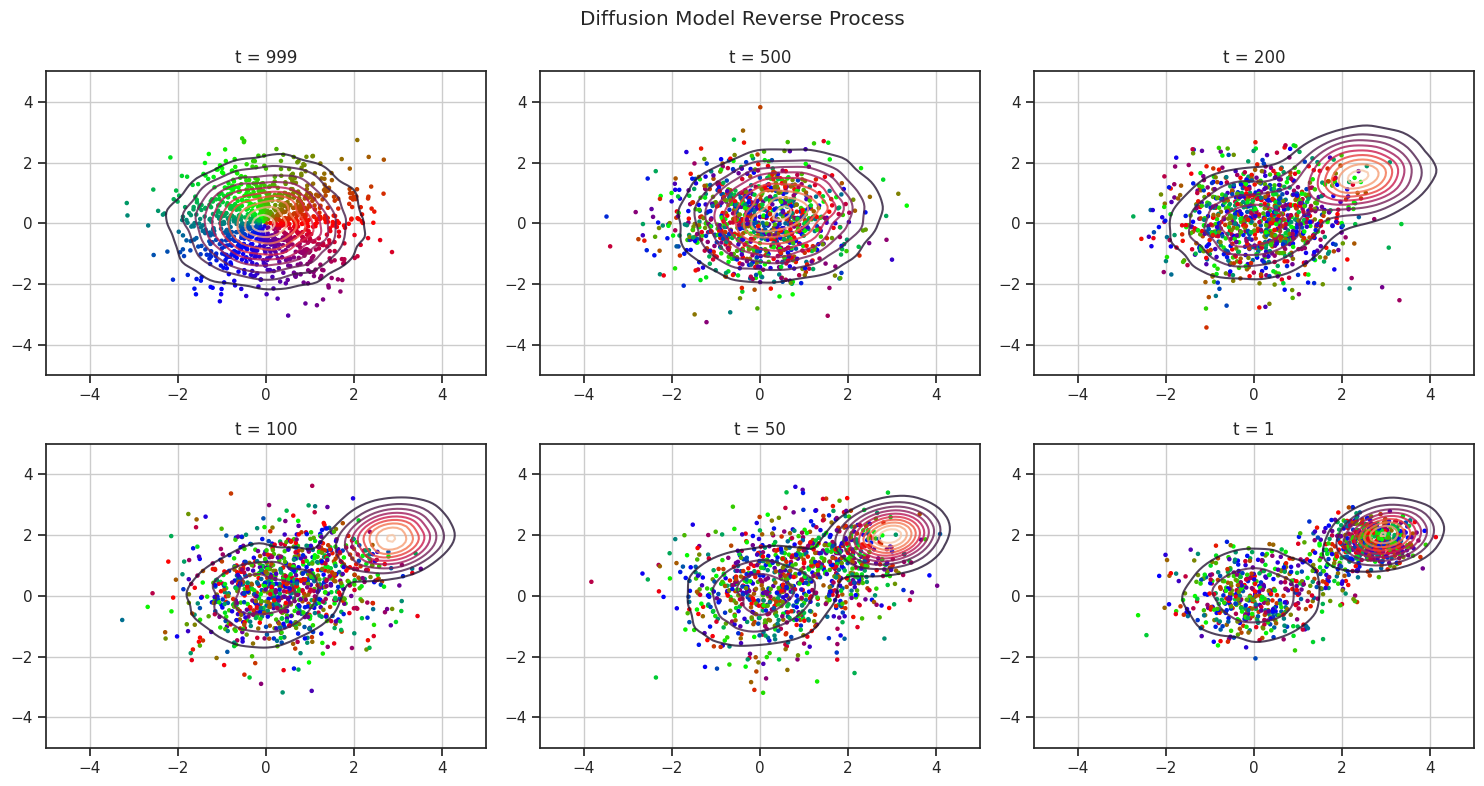

In [13]:
visualize_snapshots(snapshots)

Qualitatively, the DDPM network manages to accurate capture the two peaks in our distribution, and - best of all - it does so with a very simple and stable training process. All we need are the initial samples, and controlled perturbations with the noising schedule added on top!

Looking ahead, three important extensions of the DDPM algorithm still need to be addressed:
- Faster inference speed, primarily getting away with fewer network calls.
- Conditioning on external parameters and observations.
- And in the context of physics simulations, we'd of course like to bring back our prior knowledge in the form of PDE-base constraints.

Nonetheless, we've made the most important first step with DDPMs now: we have turned the deterministic networks into tools for probabilistic inference that robustly learn and reproduce complex distributions. So we've arrived at a very capable and stable method to learn distributions from data. The only caveat left is the computational cost. The probabilistic DDPM network require many sequential evaluations to produce a sample. These _neural function evaluations_ (NFEs) are of course costly, and while many practical cases can do with fewer than the 1000 we've used above, even 10 mean that the network is 10x slower than the "regular" deterministic version. This brings us to the last remaining step in this _generative AI journey_: how can we make the inference process faster, without negatively affecting the accuracy of our target, the inferred posterior distribution?
